In [2]:
!pip install pmdarima

!pip install keras



     |████████████████████████████████| 1.5 MB 27.4 MB/s 
     |████████████████████████████████| 9.5 MB 57.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import LSTM, Dense

from fbprophet import Prophet


# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf  # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders


from statsmodels.tsa.stattools import adfuller

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# The purpose of this notebook is to provide a light introduction to time series forecasting using one only variable (sales) and 3 basic models



Models:

*   SARIMA
*   RNN (LTSM)
*   Prophet






In [4]:
# Load data


df = pd.read_csv('/content/train.csv',index_col='date',parse_dates=True)


df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [5]:
# Resample the data so is aggregated monthly (ie total monthly sales for all stores)

df=df.resample("M").sum()


df.head()

,store,item,sales
date,,,
2013-01-31,85250,395250,454904
2013-02-28,77000,357000,459417
2013-03-31,85250,395250,617382
2013-04-30,82500,382500,682274
2013-05-31,85250,395250,763242


In [6]:
# Checking our index is in 'datetime' and the freq is corret 'M' = month end

df.index

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
      

In [7]:
# Checking for  nan values

print(df["sales"].isnull().values.any())

False


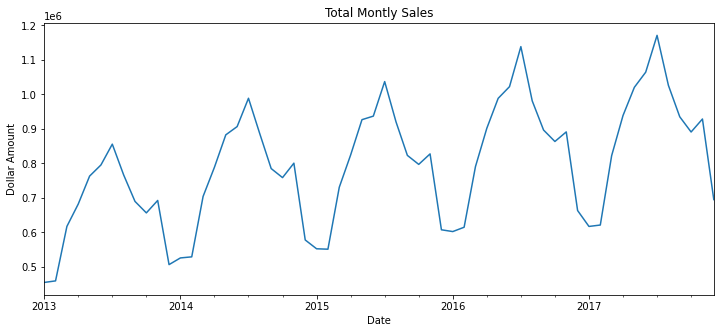

In [8]:
# From the plotting the data, it looks like there is a trend and deff seasonality (due to winter holidays)

title='Total Montly Sales'
ylabel='Dollar Amount'
xlabel = "Date"

ax = df["sales"].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

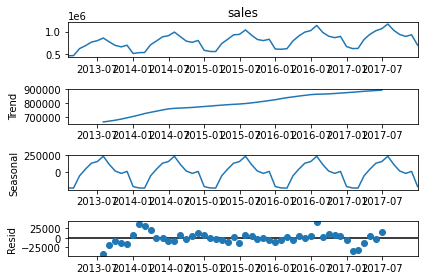

In [9]:
#Run an ETS to have a deeper look at the seasonality and trend in the data (additive becuase the trend does not appear exponential)

result = seasonal_decompose(df["sales"], model='add')
result.plot();

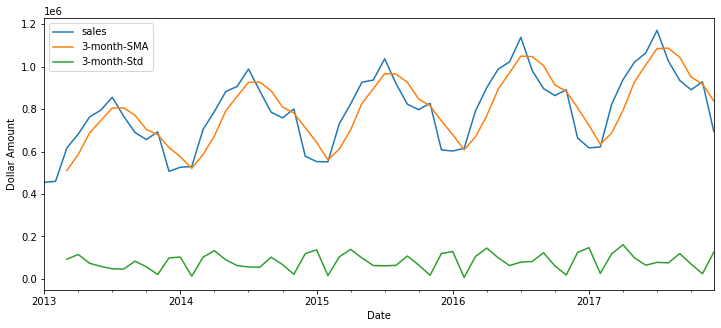

In [10]:
# Stationarity - it is quite common for time series to be non-stationary. So before moving any furhter, we need to check for stationarity (i.e. variance and  mean are constanct over time - seasonality too!)

# First plotting - the mean is not constant over time

df['3-month-SMA'] = df['sales'].rolling(window=3).mean()
df['3-month-Std'] = df['sales'].rolling(window=3).std()

ylabel='Dollar Amount'


ax = df[['sales','3-month-SMA','3-month-Std']].plot(figsize = (12,5));

ax.set(xlabel=xlabel, ylabel=ylabel);

In [11]:
#Augmented Dickey-Fuller Test is a statistical test for wether or not the data has a trend (at some level of confidence) 

# Due to the low p-value (<.05), the null-hypothesis of unit root (trend) is rejected

print('Augmented Dickey-Fuller Test')
dftest = adfuller(df['sales'],autolag='AIC')

dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Augmented Dickey-Fuller Test
ADF test statistic      -5.247519
p-value                  0.000007
# lags used             11.000000
# observations          48.000000
critical value (1%)     -3.574589
critical value (5%)     -2.923954
critical value (10%)    -2.600039
dtype: float64


In [12]:
# To deal with trend, lets manually differnce the data to see if the trend is still present

first_dif = df["sales"].diff()[1:]

In [13]:
len(first_dif)

59

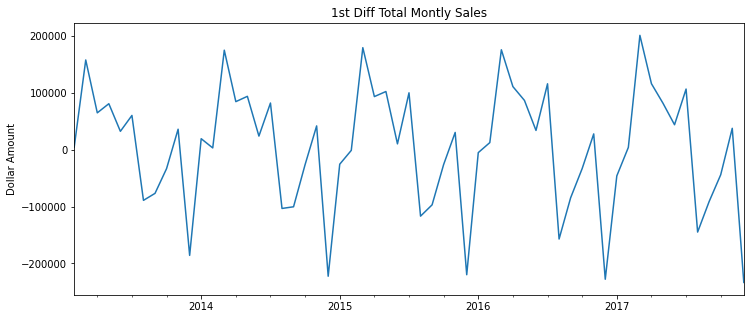

In [14]:
# First differencing removes the trend but seasonality still exist

title='1st Diff Total Montly Sales'
ylabel='Dollar Amount'
xlabel='' # we don't really need a label here

ax = first_dif.plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

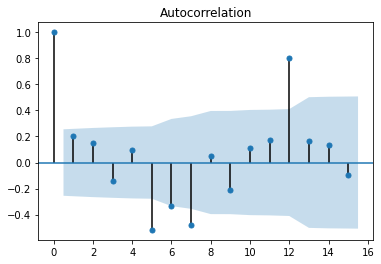

In [15]:
#Next, creating an ACF will identify the  number of lags for the seasonal MA part of the model
#Based on the chart it appears that seasonality is 12 months

# Outside blue shading is signficant 

plot_acf(first_dif, lags = 15)
plt.show()

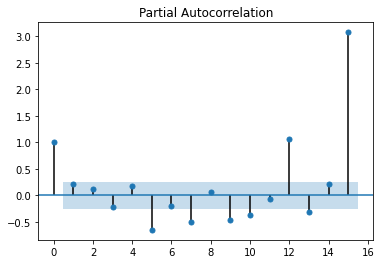

In [16]:
#The pacf chart shows the seasonal AR should contain 12 months

#lag 15 seems to be quite correlated, due to 12 month seasonality this seems odd and that it is about 1 but will be noted for when modeling (if intial 12 produces bad prediction results)

plot_pacf(first_dif, lags = 15)
plt.show()

In [17]:
# Initializing and finding the right parameters for the model

#Auto_arima performs a gird search on all model parameters and dispalys the best model

# SARIMA - due to the seasonality of the data we will use this model over an ARIMA (which is an extenstion of the ARIMA model but deals with seasonlity )
# The below auto_arima function essentially peforms a grid search for the beast model parameters


print(auto_arima (df['sales'],seasonal=True,m=12).summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2], 12)   Log Likelihood                -512.073
Date:                                 Thu, 02 Sep 2021   AIC                           1034.146
Time:                                         18:09:55   BIC                           1043.397
Sample:                                              0   HQIC                          1037.627
                                                  - 60                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0893      0.956     -0.093      0.926      -1.964       1

In [18]:
# Since none of the parameters were statically significant, lets try what we found out earliar

# First difference creates stationarity, seasonality is 12 months with one lag (ACF and PACF)

# Nice, our parameters are now statistically signficant

model = SARIMAX(df['sales'],order=(0,1,0),seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                sales   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -514.987
Date:                              Thu, 02 Sep 2021   AIC                           1035.974
Time:                                      18:09:55   BIC                           1041.524
Sample:                                  01-31-2013   HQIC                          1038.063
                                       - 12-31-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5606      0.102     -5.480      0.000      -0.761      -0.360
ma.S.L12       0.64

In [19]:
#split data into train/test

len(df)*.80



48.0

In [20]:
df_1=df.loc[:,'sales']

In [21]:
train = df_1.iloc[:48]
test = df_1.iloc[48:]

In [22]:

# Predict Values

start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions').astype(int)


In [23]:
# Compare predictions to expected values


results_table=pd.concat([test, predictions,(test-predictions) ], axis= 1).rename(columns={0:"Residuals_1"})

results_table


,sales,SARIMA Predictions,Residuals_1
date,,,
2017-01-31,617306,639629,-22323
2017-02-28,621369,631020,-9651
2017-03-31,822667,794229,28438
2017-04-30,938862,934063,4799
2017-05-31,1020686,1022777,-2091
2017-06-30,1064624,1056328,8296
2017-07-31,1171393,1180561,-9168
2017-08-31,1026403,1012897,13506
2017-09-30,935263,943307,-8044


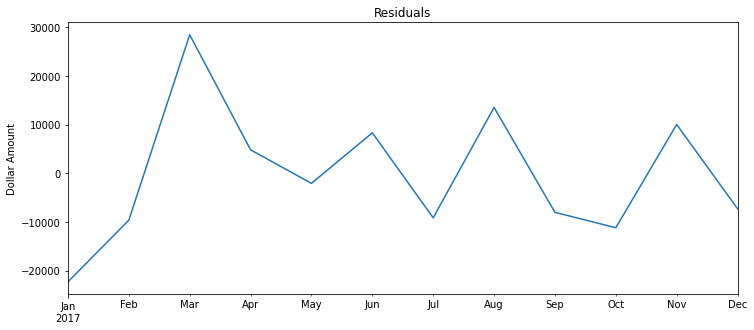

In [24]:
# Plotting the residuals - looks pretty random

title='Residuals'
ylabel='Dollar Amount'
xlabel='' # we don't really need a label here

ax = results_table["Residuals_1"].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

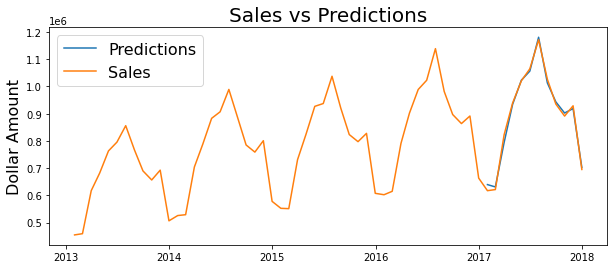

In [25]:
# Visually it looks like the model does a pretty good job at predicting sales 1 year in advance


plt.figure(figsize=(10,4))

plt.plot(results_table["SARIMA Predictions"])
plt.plot(df["sales"])

plt.legend(('Predictions', 'Sales'), fontsize=16)

plt.title('Sales vs Predictions', fontsize=20)
plt.ylabel('Dollar Amount', fontsize=16);

In [26]:
#Evaluation metrics 

print('Mean Absolute Percent Error:', round(np.mean(abs(results_table["Residuals_1"]/results_table["sales"])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(results_table["Residuals_1"]**2)))

Mean Absolute Percent Error: 0.0137
Root Mean Squared Error: 13249.321812832535


# RNN for Time Series Forecasting

In [27]:
#Since we are now working with a nueral network, the data needs to be scaled

scaler = MinMaxScaler()

scaler.fit(np.array(train).reshape(-1,1))
train_scaled= scaler.transform(np.array(train).reshape(-1,1))
test_scaled = scaler.transform(np.array(test).reshape(-1,1))
train_scaled[0:5], test_scaled[0:5]

(array([[0.        ],
        [0.00659975],
        [0.23760555],
        [0.3325027 ],
        [0.45090917]]), array([[0.23749441],
        [0.24343608],
        [0.53781145],
        [0.70773339],
        [0.82739166]]))

In [28]:
# The date needs to be formatted properly -- a 12 step sequence will be created to deal with the annual seasonality 

n_input  = 12
n_features = 1 

generator = TimeseriesGenerator(train_scaled,train_scaled,sampling_rate=1, length=n_input, batch_size=1)

In [29]:
len(train_scaled), len(generator)

(48, 36)

In [30]:
generator[0][1],generator[0][1][0]

(array([[0.10395078]]), array([0.10395078]))

In [31]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape = (n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [33]:
type(generator)

tensorflow.python.keras.preprocessing.sequence.TimeseriesGenerator

In [34]:
model.fit(generator,epochs=75)

Epoch 1/75
36/36 [==============================] - 4s 32ms/step - loss: 0.1239
Epoch 2/75
36/36 [==============================] - 1s 33ms/step - loss: 0.0769
Epoch 3/75
36/36 [==============================] - 1s 33ms/step - loss: 0.0560
Epoch 4/75
36/36 [==============================] - 1s 32ms/step - loss: 0.0517
Epoch 5/75
36/36 [==============================] - 1s 32ms/step - loss: 0.0496
Epoch 6/75
36/36 [==============================] - 1s 32ms/step - loss: 0.0505
Epoch 7/75
36/36 [==============================] - 1s 32ms/step - loss: 0.0392
Epoch 8/75
36/36 [==============================] - 1s 32ms/step - loss: 0.0264
Epoch 9/75
36/36 [==============================] - 1s 32ms/step - loss: 0.0248
Epoch 10/75
36/36 [==============================] - 1s 33ms/step - loss: 0.0212
Epoch 11/75
36/36 [==============================] - 1s 33ms/step - loss: 0.0120
Epoch 12/75
36/36 [==============================] - 1s 32ms/step - loss: 0.0123
Epoch 13/75
36/36 [==================

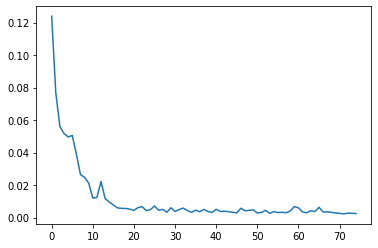

In [35]:
#Plot epochs vs MSE (loss function for the RNN)

#the model converged to its min MSE

loss = model.history.history['loss']

plt.plot(range(len(loss)),loss)
plt.show()

In [36]:
first_eval_batch = train_scaled[-12:]
first_eval_batch


array([[0.21575311],
       [0.23405926],
       [0.49132805],
       [0.6537538 ],
       [0.78065965],
       [0.83028426],
       [1.        ],
       [0.77007783],
       [0.64626784],
       [0.5977254 ],
       [0.63839582],
       [0.30491771]])

In [37]:
first_eval_batch=first_eval_batch.reshape((1,n_input,n_features))
x=model.predict(first_eval_batch)[0]
x

array([0.2585476], dtype=float32)

In [38]:
#forecasting

test_predictions = []

#first 12 data points from test test
first_eval_batch = train_scaled[-n_input:]
#reshaped to fit RNN input shape
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test_scaled)):

  
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  #removes first data and replaces with prediction
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)


In [39]:
true_predictions=scaler.inverse_transform(test_predictions)

In [40]:
results_table['RNN Predictions']=np.around(true_predictions).astype(int)
results_table['Residuals_2']= results_table["sales"]-results_table['RNN Predictions']
results_table

,sales,SARIMA Predictions,Residuals_1,RNN Predictions,Residuals_2
date,,,,,
2017-01-31,617306,639629,-22323,631702,-14396
2017-02-28,621369,631020,-9651,689775,-68406
2017-03-31,822667,794229,28438,830462,-7795
2017-04-30,938862,934063,4799,941423,-2561
2017-05-31,1020686,1022777,-2091,1040628,-19942
2017-06-30,1064624,1056328,8296,1109357,-44733
2017-07-31,1171393,1180561,-9168,1148628,22765
2017-08-31,1026403,1012897,13506,1034950,-8547
2017-09-30,935263,943307,-8044,957175,-21912


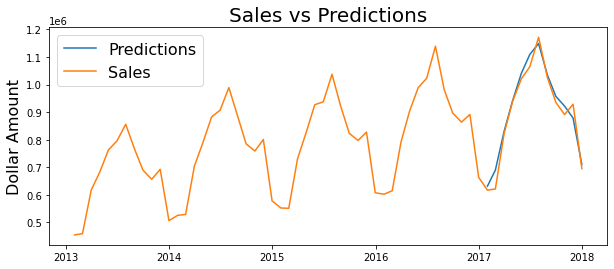

In [41]:
plt.figure(figsize=(10,4))

plt.plot(results_table["RNN Predictions"])
plt.plot(df["sales"])

plt.legend(('Predictions', 'Sales'), fontsize=16)

plt.title('Sales vs Predictions', fontsize=20)
plt.ylabel('Dollar Amount', fontsize=16);

In [42]:
print('Mean Absolute Percent Error:', round(np.mean(abs(results_table["Residuals_2"]/results_table["sales"])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(results_table["Residuals_2"]**2)))

Mean Absolute Percent Error: 0.0307
Root Mean Squared Error: 31784.98040217528


# Prophet 


In [43]:
#Prophet requires a diff data format than the SARIMA model

df.head()

,store,item,sales,3-month-SMA,3-month-Std
date,,,,,
2013-01-31,85250,395250,454904,NaN,NaN
2013-02-28,77000,357000,459417,NaN,NaN
2013-03-31,85250,395250,617382,510567.666667,92531.444095
2013-04-30,82500,382500,682274,586357.666667,114621.954949
2013-05-31,85250,395250,763242,687632.666667,73077.502566


In [44]:
#Formatting requirement - time stamp labelled as 'ds' and sales as "y"

df_proph = df[["sales"]]

df_proph.reset_index(level=0, inplace=True)

df_proph.rename(columns={"date":"ds","sales":"y"},inplace=True)

df_proph["ds"]= pd.to_datetime(df_proph["ds"]) #time stamp needs to be in to_datetime format

df_proph.head()

,ds,y
0,2013-01-31,454904
1,2013-02-28,459417
2,2013-03-31,617382
3,2013-04-30,682274
4,2013-05-31,763242


In [45]:
#Creating training and test set

len(df_proph)*.80

48.0

In [46]:
train = df_proph.iloc[:48,:]
test = df_proph.iloc[48:,:]

In [47]:
#Intiate the model

model_proph = Prophet()

#Fit the model

model_proph.fit(train)

#Create a dataframe for predictions

future= model_proph.make_future_dataframe(periods=12, freq="M")

len(future) #lenght matches orginal dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


60

In [48]:
predit_proph = model_proph.predict(future)

In [49]:
#the two import columns are "ds" (time stamp) and "yhat" (predictions)

predit_proph.columns



Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [50]:
results_table['Proph Predictions'] = list(map(int,predit_proph["yhat"][-12:]))

results_table['Residuals_3']= results_table["sales"]-results_table['Proph Predictions']

results_table

,sales,SARIMA Predictions,Residuals_1,RNN Predictions,Residuals_2,Proph Predictions,Residuals_3
date,,,,,,,
2017-01-31,617306,639629,-22323,631702,-14396,712228,-94922
2017-02-28,621369,631020,-9651,689775,-68406,699799,-78430
2017-03-31,822667,794229,28438,830462,-7795,871520,-48853
2017-04-30,938862,934063,4799,941423,-2561,962749,-23887
2017-05-31,1020686,1022777,-2091,1040628,-19942,1053696,-33010
2017-06-30,1064624,1056328,8296,1109357,-44733,1085903,-21279
2017-07-31,1171393,1180561,-9168,1148628,22765,1179991,-8598
2017-08-31,1026403,1012897,13506,1034950,-8547,1057645,-31242
2017-09-30,935263,943307,-8044,957175,-21912,970595,-35332


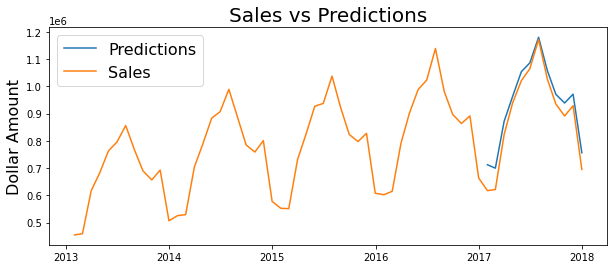

In [51]:
plt.figure(figsize=(10,4))

plt.plot(results_table["Proph Predictions"])
plt.plot(df["sales"])

plt.legend(('Predictions', 'Sales'), fontsize=16)

plt.title('Sales vs Predictions', fontsize=20)
plt.ylabel('Dollar Amount', fontsize=16);

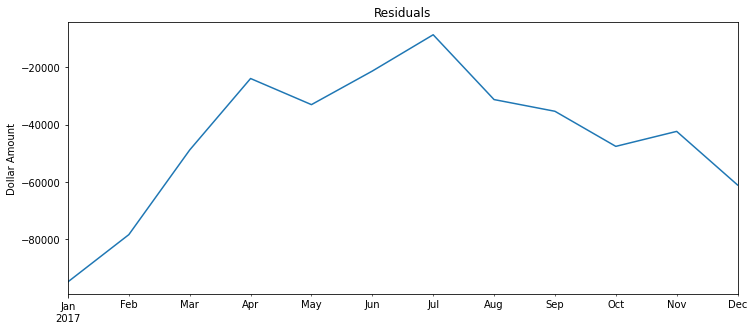

In [52]:
# The residuals are not random

title='Residuals'
ylabel='Dollar Amount'


ax = results_table["Residuals_3"].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

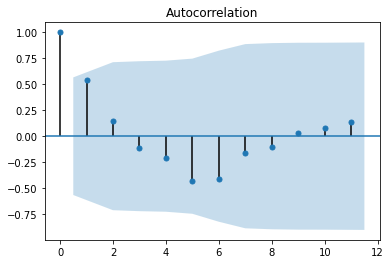

In [53]:
# No serial correlation in the residuals

# Still not happy wit the overpredicting of the model.. (since I am not pro in Prophet, I'll save this for another notebook with an indepth tutorial on Prophet)

plot_acf(results_table["Residuals_3"])
plt.show()

In [54]:


print("*********SARIMA**********")
print('Mean Absolute Percent Error:', round(np.mean(abs(results_table["Residuals_1"]/results_table["sales"])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(results_table["Residuals_1"]**2)))
print("")

print("*********LTSM**********")
print('Mean Absolute Percent Error:', round(np.mean(abs(results_table["Residuals_2"]/results_table["sales"])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(results_table["Residuals_2"]**2)))
print("")

print("*********Prophet**********")
print('Mean Absolute Percent Error:', round(np.mean(abs(results_table["Residuals_3"]/results_table["sales"])),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(results_table["Residuals_3"]**2)))

*********SARIMA**********
Mean Absolute Percent Error: 0.0137
Root Mean Squared Error: 13249.321812832535

*********LTSM**********
Mean Absolute Percent Error: 0.0307
Root Mean Squared Error: 31784.98040217528

*********Prophet**********
Mean Absolute Percent Error: 0.0566
Root Mean Squared Error: 49790.8746090419


# In Summary:

A simple seasonal ARIMA model (SARIMA) outperformed a RNN (LTSM) and Facebook's Prophet model. Important to consider is the data lacked complexity due to being monthly and had no exongenous variables (i.e. hoildays) or covariates (other lagged time series)

Thus, with more naunced data using classical time series models can be  difficult to tune for optimal results and the two other models may be a better option. Just remember, as a Data Scientest it is always best practice to try out various models on a data set for the best results (if time permits). 